# Detection of an unknown pulsar and measurement of its period using <mark> Fourier analysis </mark>

In [17]:
# Preamble and imports
from __future__ import (print_function, absolute_import, division)

import os
import numpy as np
from  matplotlib import pyplot as plt
import matplotlib
from math import pi
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

%matplotlib inline

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

# 1. <mark>All Functions</mark>

All the functions used for the analysis are described in this section.

## 1.1 Importing data
The data for the 6 pulsar data sets have been imported.

In [18]:
# Get the directory with the data
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "Data", "FFT")

def get_header(file_name):
    """
    Function that reads in the header files.
    
    @param file_name :: name of the file
    
    @returns :: contents of header file as array
                of lines
    """
    
    file_name = file_name + '.hdr'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        lines = dfile.readlines()
        for i, line in enumerate(lines):
            lines[i] = line.strip()
    
    return lines

###################################################################################
def get_data(file_name):
    """
    Function that returns the data in the files.
    
    @param file_name :: name of the file
    
    @returns :: contents of the data file
                in one numpy array
    """
    
    file_name = file_name + '.dat'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        data = np.fromfile(dfile, dtype='b')
    
    return data

## 1.2 Demonstration of the power of Fourier Transform using simulated data

Fake noise and data is simulated to show understand the results obtained from Fourier analysis.

In [19]:
def generate_times(dt, npts):
    """
    Generate the times for the demo.
    
    @param dt :: interval between times
    @param npts :: number of time points
    
    @returns :: array of times
    """

    times = np.linspace(0,(npts-1)*dt,npts)
    
    return times

###################################################################################
def generate_signal(times, period):
    """
    Generates the fake signal.
    
    @param times :: array of times
    @param period :: period of the signal
    
    @returns :: fake signal
    """
    
    fake_signal = np.sin(2*pi*times/period)
    
    return fake_signal

###################################################################################    
def generate_noise(npts):
    """
    Generates random noise.
    
    @param npts :: number of points
    
    @returns :: random distributed noise
    """
    
    random_noise = np.random.normal(0,20,npts)
    
    return random_noise

## 1.3 Plotting the <u>'simulated data'</u> & <u>'time series'</u>

The <mark>simulated data</mark> plots show an example showing the power of Fourier analysis. 

The <mark>time series</mark> for the 6 pulsar data sets is plotted.

In [20]:
def raw_plot(times, raw_bytes, fake_signal):
    """
    Plots the raw simulated data with the signal.
    
    @param times :: array of times
    @param raw_bytes :: array of data
    @param fake_signal :: fake signal data
    
    @returns :: plot of the signal with the data
    """
    
    plt.figure(figsize=(10,3))
    plt.plot(times, raw_bytes)
    plt.plot(times, fake_signal, color='red')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Simulated noise plus sinusoidal signal")

###################################################################################
def signal_plot(times, raw_bytes, fake_signal):
    """
    Signal plot of the data (zoomed in)
    
    @param times :: array of times
    @param raw_bytes :: array of data
    @param fake_signal :: fake signal data
    
    @returns :: plot of the signal with data zoomed in
    """
    
    plt.figure(figsize=(10,3))
    plt.plot(times, raw_bytes)
    plt.plot(times, fake_signal, color='red', linewidth=2)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Zoomed to show signal amplitude")
    plt.xlim(0,5)
    plt.ylim(-3,3)
    
###################################################################################    
def time(data_header, data, pulsar_no):
    """
    Plots the input data as a function of time
    
    @data_header :: header file with info about "sampling_perion"
    @data :: file with the input data
    
    @return :: plot of the amplitude as a function of time
            :: integration time
    """
    if (data_header != psr5_header):    
        sampling_period = float(data_header[-2][5:-1])          
    else:
        sampling_period = float(data_header[-1][5:-1])          
    
    int_time        = sampling_period*len(data)*(pow(10, -3))   
    period_array    = np.linspace(0, int_time, num=len(data))   
    
    plt.figure(figsize=(10,3))
    plt.plot(period_array, data, color = 'green', linewidth=2)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title('Time series: Pulsar %s'%pulsar_no)
    return int_time       

## 1.4 Fourier Transform of the time series data

The Fourier transform of the time series is calculated. The corresponding <u>frequencies are carlibrated</u> to physical values and the power spectrum is plotted. The peaks in the power spectrum are recorded with the corresponding harmonics.

In [21]:
def fourier_transform(raw_bytes):
    """
    Fourier transforms data.
    
    @param raw_bytes :: the data
    
    @returns :: the power of the fourier transformed
                data
    """
    
    ft = np.fft.rfft(raw_bytes)
    power = np.real(ft)*np.real(ft) + np.imag(ft)*np.imag(ft)
    return power

###################################################################################
def frequencyArray(power, int_time, limits):
    """
    Calculates the frequency array for the corresponding  power array
    Eliminates the regular spikes observed at 50 Hz :: Reason yet to be resolved
    
    @param power :: power array from the  fft
    @param int_time :: integration time for the corresponding pulsar
    
    @returns :: frequency array for the calibration of x-axis
    """
    # Starting point of the frequency array
    freq_start_pt   = 1/int_time                                
    freq_array = np.linspace(freq_start_pt, freq_start_pt*len(power), num=len(power))
   
    # k corresponding to the frequency to be eliminated
    for i in range(len(limits)):
        a = np.where(((freq_array >= limits[i][0]) & (freq_array <=limits[i][1]))) 
        freq_array = np.delete(freq_array, a)                        
        power = np.delete(power, a)  

    return freq_array, power

###################################################################################    
def findingPeaksPlot(dist, power, freq, x):
    """
    Function finds the peaks in the plot
    
    @param power :: power spectrum with peaks
    @param  dist :: allows to input minimum distance required between peaks
    @param     x :: pulsar number  
    
    @returns        :: Plot with the peaks
    """
    # finds the peaks and the period == distance between peaks
    peak, _ = find_peaks(power, distance=dist)
     
    # plots the data 
    plt.figure(figsize=(7,7))
    plt.plot(freq[peak], power[peak], "ro")
    plt.plot(freq, power, 'g-')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Power spectrum: Pulsar {}".format(x))
    plt.tight_layout()
    
    return freq[peak]

## 1.5 Cutting noise & Correncting the harmonic number
    
The noise arising from AC current at 50 Hz, 100 Hz, 150 Hz, and so on was eliminated. Additionally attempts were made to eliminate low non-signal power for pulsar 2. 

The harmonic numbers were corrected at the points where the signal was eliminated with the noise.

In [22]:
def sliceAfter(f, p, m):
    """
    Function slices the arrays of frequency and power as per input value (m, n, & o)
    
    @param f :: Frequency arrays for the pulsar
    @param p :: Power arrays for the pulsar
    @param m :: frequency value at which the pulsars are sliced
    
    @returns f_ :: sliced frequency arrays
             p_ :: sliced power arrays  
    """
    # index values at which the arrays are being sliced
    idxDes = np.where(f < m);
    
    f_ = f[idxDes];
    p_ = p[idxDes];
    
    return f_, p_

###################################################################################
def removeNoise(f1, p1, x):
    """
    Function removes the noise from pulsar 2
    
    @param      f1 :: freuency array of pulsar 2
    @param      p1 :: power array of pulsar 2
    
    @returns f1new :: new frequncy array with noise eliminated
             p1new :: new power array with noise eliminated        
    """
    idxKeep = np.where(p1 > x)
    p1new = p1[idxKeep]
    f1new = f1[idxKeep]
    
    return f1new, p1new

###################################################################################
def correting_harmonic(f_peak, x, m):
    """
    corrects the harmonic number and plots the corrected graph
    
    @param f_peak :: frequency values of the peak
    @param m :: thershold for difference between peak frequencies
    @param x :: pulsar number
    
    @returns new_harmonic :: new harmonics arrays
    @returns n :: total number of harmonics
    """
    harmonic = np.linspace(1, len(f_peak), num=len(f_peak))

    # calculates the frequencies peaks' differences & find indicies with frequncy > m
    diff_freq = np.diff(f_peak)
    idx_diff = np.where(diff_freq > m)[0]
    new_harmonic = harmonic
    
    # changes the harmonic arrays
    for i in range(0, len(idx_diff)):
        new_harmonic = np.concatenate((new_harmonic[:(idx_diff[i]+1)],
                                  new_harmonic[(idx_diff[i]+1):]+1))
    # plots the corrected graph
    plt.figure(figsize=(7,7))
    plt.plot(f_peak, new_harmonic,  "ro", label='Corrected Harmonics')
    plt.plot(f_peak, harmonic,  "gX", label='Original Harmonics')
    plt.plot(f_peak[idx_diff], harmonic[idx_diff],  "m^", label='Points of increment')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("No. of Harmonic")
    plt.title("Frequency vs Harmonics Number: Pulsar {}".format(x))
    plt.legend(loc='upper left', prop={'size': 15})
    plt.show()
    
    # calculates the last harmonic number
    n = new_harmonic[-1]
    
    return new_harmonic, n

## 1.6 Method I: Calculation of period and estimation of uncertainties

<span style="color:red">
This method involves calculation of the period from the slope of the frequency vs harmonics plot. </span>

The slope rises as $1/p$. The uncertainties on the frequency arise from the resolution limitation due to the sampling rate. They are used to obtain the uncertainty of the slope by doing a weighted linear-fit. 

In [23]:
def linear_fitting(harmonics, frequency, pulsar_no, res_f, err_f):
    """
    applies a linear fitting and calculates the chi-square
    
    @param harmonics :: x input array
    @param frequency :: y input array
    @param pulsar_no :: pulsar no. used while printing functions
    @param res_f :: minimum resolution of the bins, set as uncertainty in period
    @param err_p :: fitting error
    
    @returns harmonic_fit :: y best fit array 
    """
    def f(x, m, c):
        return m*x + c
    # fitting
    sigma = np.ones(harmonics.size)*res_f
    popt, pcov = curve_fit(f, harmonics, frequency, sigma=sigma, absolute_sigma=True)
    frequency_fit = f(harmonics, *popt)
    
    #(coef, covr) = np.polyfit(harmonics, frequency, 1, cov=True)
    #eqn_of_fit = np.poly1d(coef)
    #frequency_fit = eqn_of_fit(harmonics)
    
    err_v = np.sqrt(pcov[0][0])
    err_p = pow((1/popt[0]), 2)*err_v
    
    # chi-sqaure
    res = frequency_fit - frequency
    chisq = sum(pow(res/res_f, 2))
    chisq_red = chisq/(len(harmonics)-2)
    
    print('Period of Pulsar %s : %.4f ± %.4f (res) ± %.4f (fit) seconds\n'%(pulsar_no, 
                                                                            1/popt[0], 
                                                                            res_f, err_p))
    #print(' χ2: %.4f \n χ2 reduced: %.4f\n'%(chisq, chisq_red))
    return frequency_fit, 1/popt[0]       

###################################################################################
def delete_points(arr1, arr2, m):
    """
    function deletes outliers
    @param arri (i=1,2) :: first array which is to be modifie
    @param m :: index of the element which is to be deleted
    
    @returns arri_ (i=1,2) :: new arr1 with the m index deleted
   """
    arr1_ = np.delete(arr1, m)
    arr2_ = np.delete(arr2, m)
    return arr1_, arr2_

###################################################################################
def plot_fit(x, y, yfit, weight, pulsar_no):    
    """
    plots (1) best fit and data, 
          (2) residuals
    
    @param x :: x array
    @param y :: y data array
    @param pulsar_no :: pulsar number used for formatting the strings (label)
    
    @return :: plots of best fit and residuals 
    """
    fig = plt.figure(figsize=(25,6.5))
    plt.subplot(121)
    frequency_errors=weight*(np.ones(len(y)))
    plt.errorbar(x, y, yerr=frequency_errors, fmt='go', ecolor='black', label='Data')
    plt.plot(x, yfit, 'r-', label='Best Fit')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Harmonics')             
    plt.title('Linear Fit: Pulsar %s'%(pulsar_no))
    plt.legend(loc='upper left', prop={'size': 15})
    
    res = y - yfit        
    plt.subplot(122)
    plt.errorbar(x, res, yerr=frequency_errors, fmt='go', ecolor='black')
    plt.axhline(y=0., color='r', linestyle='-')
    plt.ylabel('Residuals (Frequency)')
    plt.xlabel('Harmonics')             
    plt.title('Residuals %s'%(pulsar_no))                
    plt.subplots_adjust(bottom=0.1, right=0.85)
    plt.show()  

###################################################################################    
def cal_width(period, new_harmonics, err_period, pulsar_no):
    """
    calculates the width of the pulse
    @param period :: period of the pulse
    @param new_harmonics :: corrected harmonics 
    @param pulsar_no :: pulsar number used for formatting string
    
    @return width :: width of the pulse
    """
    width = period/(2*new_harmonics[-1])
    err_width = width*np.sqrt((err_period/(2*new_harmonics[-1]))**2 + (1/new_harmonics[-1])**2)
    print('Width of Pulsar %s ~ (%.5f ± %.5f)s\n'%(pulsar_no, width, err_width))
    return width, err_width

## 1.7 Method II : Calculation of period and estimation of uncertainties

<span style="color:red">
This method involves calculating the period, by measuring the distance between consecutive frequency peaks. </span>

This distance, $d = f_{peak+1}- f_{peak}$,    is given as 1/$p$. The uncertainty on the $p$ was propogated from the frequency $f_{peak}$ which arose from the resolution limitation due the set sampling rate. 

In [24]:
def cal_period(freq, res_f_):
    """
    function calculates the period array and uncertainty on the individual points due
    to resolution limitations
    
    @param freq :: frequency array of the peaks
    @res_f_ :: resolution of the frequency bin
    
    @return p_peak :: array with the peak periods
    @return p_peak_err :: array with errors on the peak period
    """
    # defining the required quantities
    diff_freq = np.diff(freq)
    p_peak = 1/diff_freq
    
    # calculating the errors
    error_frequency = ((res_f_)*np.sqrt(2))
    p_peak_err = (p_peak**2)*error_frequency
    
    return p_peak, p_peak_err
    
###################################################################################
def plot_period(new_h_, p_peak, p_peak_err, pulsar_no):    
    """
    plots the period as a function of the harmonics
    @param new_h_ :: new harmonics array with the outlier points deleted
    @param p_peak :: array with the period between two consequtive points
    @param p_peak_err :: uncertainty on periods calculated by considering resolution
    
    @return mean_period :: the final mean value for the period, as shown in the graphs
    @return 3*std_period :: 3 times the stdev in the mean period considered as 
                            the uncertainty on the period measurements
    """
    # calculating the mean, std and printing the answers
    mean_period = np.mean(p_peak)
    std_period = np.std(p_peak)
    legend_label = 'Mean Period = %.4f'%(mean_period)
    print('Mean Period = %.4f +- %.4f(std)'%(mean_period, 3*std_period))
    
    # plotting the figure with mean period
    plt.figure(figsize=(10,5))
    # eliminating the last element in new_h_ to make arrays of the same length
    plt.errorbar(new_h_[:-1], p_peak, yerr=p_peak_err, fmt='go', label='Data')
    plt.axhline(y=mean_period, color='r', linestyle='-', label=legend_label)
    plt.axhline(y=(mean_period+3*std_period), color='r', linestyle='--', label='+/- 3*sigma =%.4f'%(3*std_period))
    plt.axhline(y=(mean_period-3*std_period), color='r', linestyle='--')
    plt.axhline(y=mean_period, color='r', linestyle='-')
    plt.ylabel('Periods (seconds)')
    plt.xlabel('Harmonics')             
    plt.title('Pulsar %s'%pulsar_no)
    plt.legend(loc='upper left', prop={'size': 15})
    plt.show()
    return mean_period, 3*std_period

###################################################################################
def delete_3_arr_points(arr1, arr2, arr3, m):
    """
    function deletes outlier points in an array
    
    @param arr1 :: 1st input array
    @param arr2, arr3 :: 2nd and 3rd input array
    @param m :: index of the point to be deleted
    
    @return arr1_, arr2_, arr3_ :: the new arrays with the m index deleted 
    """
    arr1_ = np.delete(arr1, m)
    arr2_ = np.delete(arr2, m)
    arr3_ = np.delete(arr3, m)
    return arr1_, arr2_, arr3_   

# 2. <mark>Kowalsky, Analysis.</mark>

## 2.1 Demonstration of the power of Fourier Transform using simulated data

Fake data has been simulated and the Fourier analysis is applied. The excersice is intructive to understand the use of Fourier Transform.

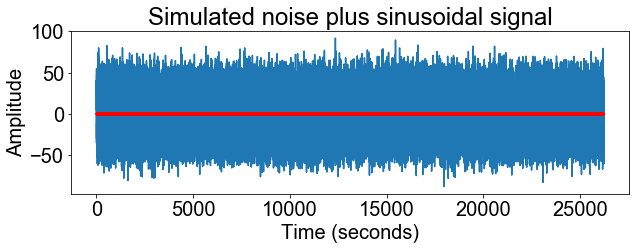

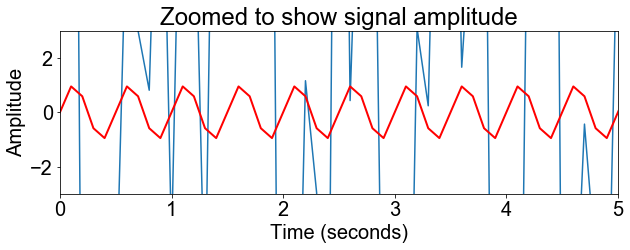

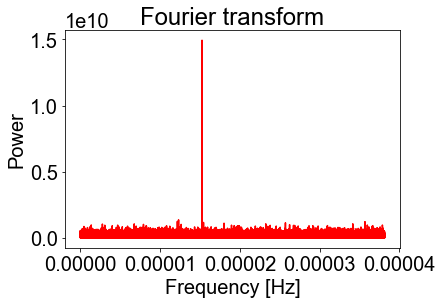

In [25]:
# Choose time interval and number of points
dt = 0.1
npts = 262144
period = 0.5

# Generate data
times           = generate_times(dt, npts)
fake_signal     = generate_signal(times, period)
noise           = generate_noise(npts)
raw_bytes       = noise + fake_signal

# Plot data
raw_plot(times, raw_bytes, fake_signal)
signal_plot(times, raw_bytes, fake_signal)
p = fourier_transform(raw_bytes)

# plotting the data
fig, ax = plt.subplots()
fake_frequency  = np.linspace((1/sum(times)), len(p)*(1/sum(times)), num=len(p))
plt.plot(fake_frequency, p, 'r-')
plt.xlabel("Frequency [Hz]")
# format the x axis such that labels don't overlap
plt.ylabel("Power")
plt.title("Fourier transform")
every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

## 2.2 Plotting the time series for the pulsars

The 6 pulsar data sets obtained from the 76-m Lovell telescope is used for this exercise. The time of integration is obtained from the header files. The corresponding time-series for each pulsar is plotted.

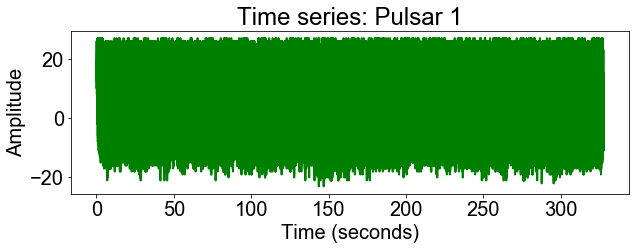

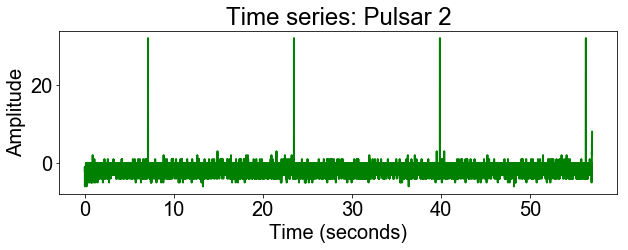

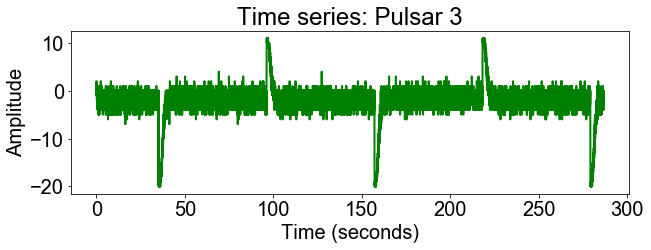

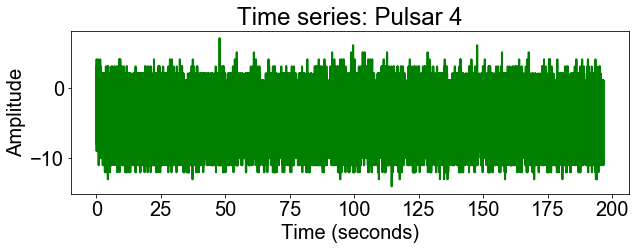

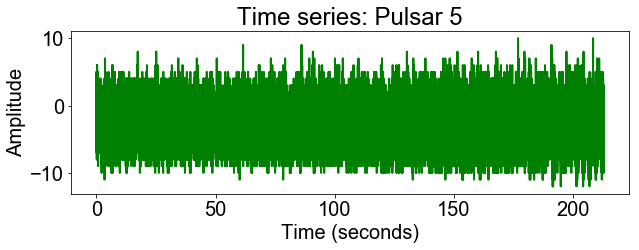

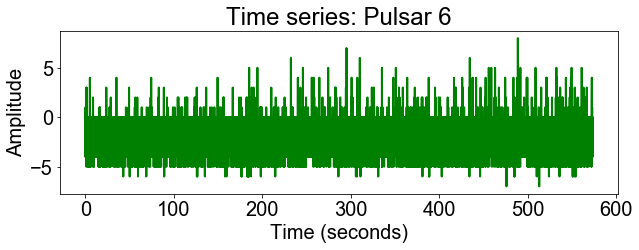

In [26]:
# reading the data
psr0 = get_data('psr0');
psr1 = get_data('psr1');
psr2 = get_data('psr2');
psr3 = get_data('psr3');
psr4 = get_data('psr4');
psr5 = get_data('psr5');

# reading the header files
psr0_header = get_header('psr0');
psr1_header = get_header('psr1');
psr2_header = get_header('psr2');
psr3_header = get_header('psr3');
psr4_header = get_header('psr4');
psr5_header = get_header('psr5');

# plotting the time series
int_time0 = time(psr0_header, psr0, '1')
int_time1 = time(psr1_header, psr1, '2')
int_time2 = time(psr2_header, psr2, '3')
int_time3 = time(psr3_header, psr3, '4')
int_time4 = time(psr4_header, psr4, '5')
int_time5 = time(psr5_header, psr5, '6')

# resolution of the frequency - used as error estimate later
res_f_0 = 1/int_time0 
res_f_1 = 1/int_time1
res_f_2 = 1/int_time2
res_f_3 = 1/int_time3
res_f_4 = 1/int_time4
res_f_5 = 1/int_time5

## 2.3 Plotting the Power Spectrum for Fourier transform of the time series

The fourier transform of the time series is plotted. The peaks in the frequency spectrum are identified and used to calculated the period and width (detailed in the next sections) of the pulse profile. The noise and RFI (at multiples of 50 Hz) is also eliminated in each pulsar. 

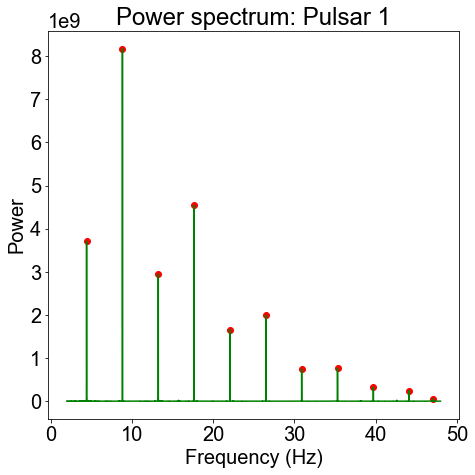

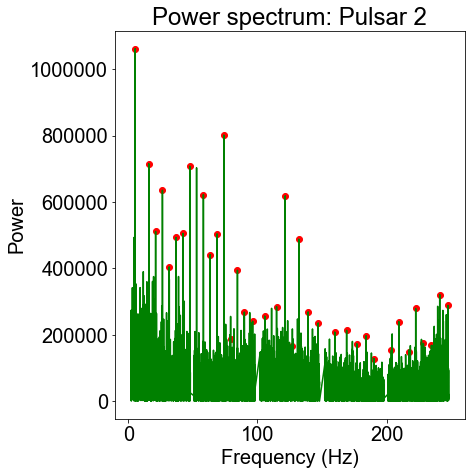

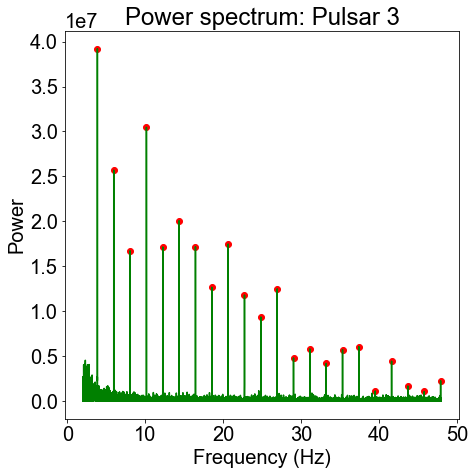

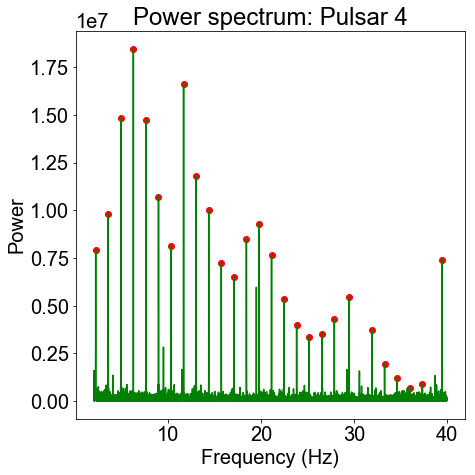

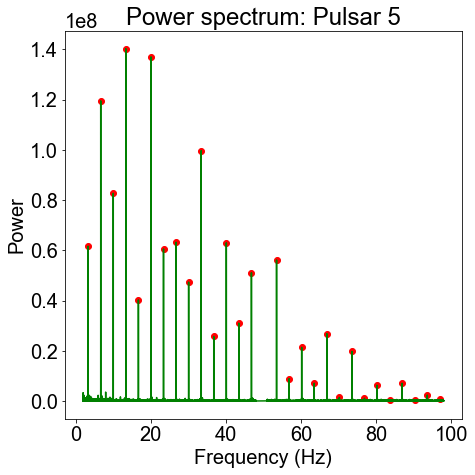

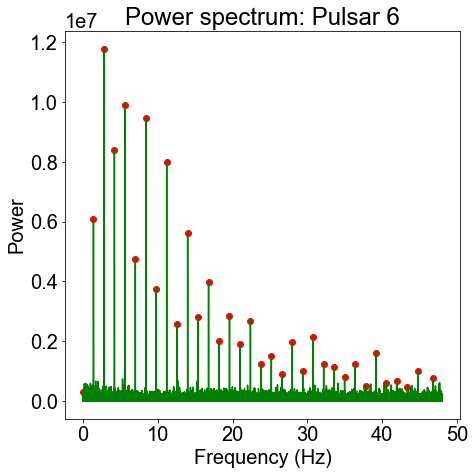

In [27]:
# calculates the power to plot the power spectrum using FFT
power0 = fourier_transform(psr0)[1:]
power1 = fourier_transform(psr1)[1:]
power2 = fourier_transform(psr2)[100:]
power3 = fourier_transform(psr3)[100:]
power4 = fourier_transform(psr4)[1:]
power5 = fourier_transform(psr5)[1:]

# eliminates suspicious cuts observed in the data
cuts = [[0, 2],[48, 51], [98,102],[148, 152],[198,201],[248, 251],[298, 301]]

# calcultes the frequency and power array to plot after elimiting cuts
freq0, power0 = frequencyArray(power0, int_time0, cuts)   
freq1, power1 = frequencyArray(power1, int_time1, cuts)
freq2, power2 = frequencyArray(power2, int_time2, cuts)
freq3, power3 = frequencyArray(power3, int_time3, cuts)
freq4, power4 = frequencyArray(power4, int_time4, cuts)
freq5, power5 = frequencyArray(power5, int_time5, cuts[1:])

# removes noise from pulsar 2: **discarded** as signal points disappear too.
f1_, p1_ = removeNoise(freq1, power1, 100000)

# calculetes the points at which the arrays need to be sliced
f2_, p2_ = sliceAfter(freq2, power2, 50);
f3_, p3_ = sliceAfter(freq3, power3, 40);
f4_, p4_ = sliceAfter(freq4, power4, 100);
   
# finds the periods, outlier's false harmonic, period of the outlier, new_period array
f_peak0      = findingPeaksPlot(900, power0, freq0, '1')
f_peak1i    = findingPeaksPlot(300, power1, freq1, '2')
f_peak2ii    = findingPeaksPlot(600, p2_, f2_, '3')
f_peak3ii    = findingPeaksPlot(250, p3_, f3_, '4')
f_peak4ii    = findingPeaksPlot(700, p4_, f4_, '5')
f_peak5      = findingPeaksPlot(800, power5, freq5, '6')

## 2.4 Correcting the number of harmonics

Due to elimination of noise at multiples of 50 Hz, some of the useful signal peaks were lost. This has been accounted for by correcting the harmonic number.

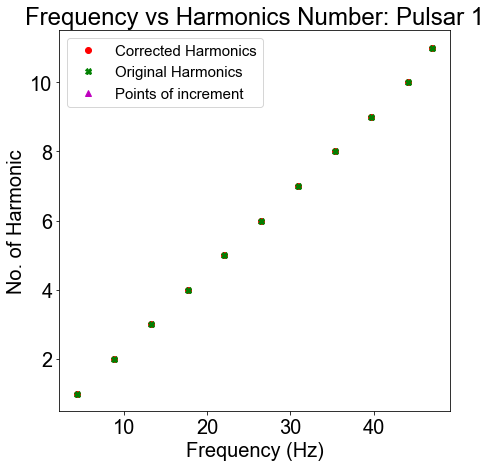

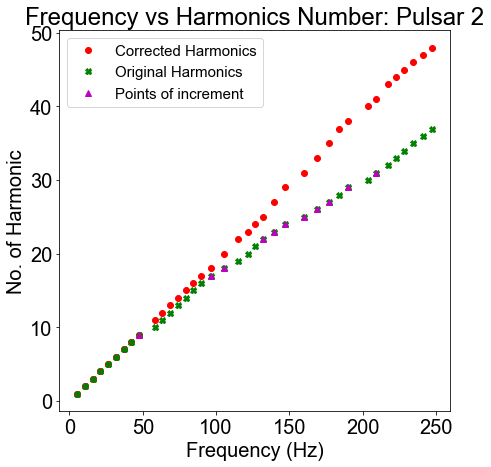

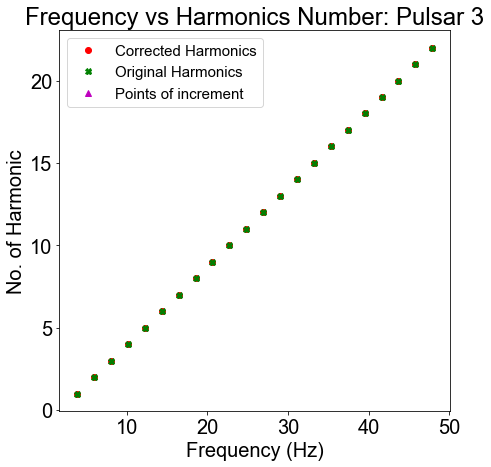

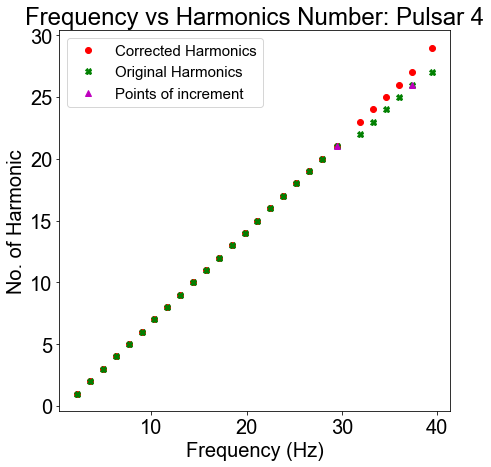

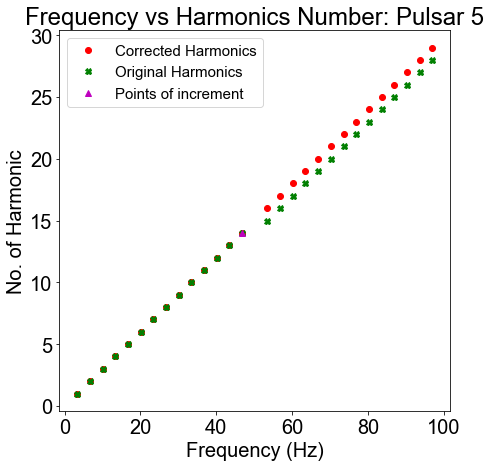

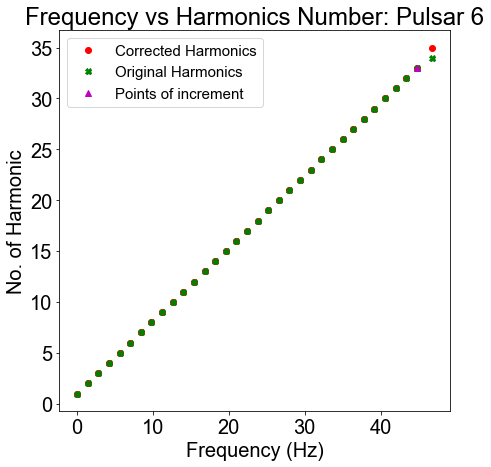

In [28]:
# printing out the difference in frequency arrays to do a manual check for missing harmonics
diff_freq0 = np.diff(f_peak0)
#print(diff_freq0)
diff_freq1i = np.diff(f_peak1i)
#print(diff_freq1i)
diff_freq2ii = np.diff(f_peak2ii)
#print(diff_freq2ii)
diff_freq3ii = np.diff(f_peak3ii)
#print(diff_freq3ii)
diff_freq4ii = np.diff(f_peak4ii)
#print(diff_freq4ii)
diff_freq5 = np.diff(f_peak5)
#print(diff_freq5)

# calculates the new harmonics and the harmonic number
new_h_0, n_0  = correting_harmonic(f_peak0, '1', 5)
new_h_1i, n_1i = correting_harmonic(f_peak1i, '2', 7)
new_h_2ii, n_2ii = correting_harmonic(f_peak2ii, '3', 4)
new_h_3ii, n_3ii = correting_harmonic(f_peak3ii, '4', 2)
new_h_4ii, n_4ii = correting_harmonic(f_peak4ii, '5', 5)
new_h_5, n_5 = correting_harmonic(f_peak5, '6', 1.5)

## 2.5 <mark>Method I:</mark> Calculation of the period and uncertainty

<span style="color:red">
The frequency peaks are ploted as a function of the harmonic number and a linear model is applied.
</span> 

The period, $p$, is calculated from the slopd of the linear-fit as, the slope, $m$ can be given as,
$$m = 1/p = v_N/N$$
where $v_N$ is the frequency of the $N^{th}$ harmonic and $N$ is the corresponding harmonic number. The uncertainty has been estimated from the covariance matrix obtained from the best fit. The errors on the frequency are accounted for by considering the minimum width of the frequency bin. This is set by the finite sampling rate.

In [29]:
print('The periods of the 6 pulsars are:\n')

# ------------------------  PULSAR 1 -----------------------------------
new_h_0_ = new_h_0[:-1]
f_peak0_ = f_peak0[:-1]
freq_fit0, p0 = linear_fitting(new_h_0_, f_peak0_, '1', res_f_0, 0.0002) 

# ------ deleted points, -15 --> -4 --> -5 : PULSAR 2 ------------------
if len(f_peak1i[:-15])==22:
    f_peak1i_, new_h_1i_ = delete_points(f_peak1i[:-15], new_h_1i[:-15], -4)

if len(f_peak1i_)== 21:  
    f_peak1i_new, new_h_1i_new = delete_points(f_peak1i_, new_h_1i_, -5)
freq_fit1, p1 = linear_fitting(new_h_1i_new, f_peak1i_new, '2', res_f_1, 0.006) 

# ------------------------  PULSAR 3 -----------------------------------
freq_fit2, p2 = linear_fitting(new_h_2ii, f_peak2ii,'3', res_f_2, 0.0008) 

# ------------------------  PULSAR 4 -----------------------------------
new_h_3_ = new_h_3ii[:-7]
f_peak3_ = f_peak3ii[:-7]
freq_fit3, p3 = linear_fitting(new_h_3_, f_peak3_, '4', res_f_3, 0.0015) 

# ------------------------  PULSAR 5 -----------------------------------
new_h_4_ = new_h_4ii[:-5]
f_peak4_ = f_peak4ii[:-5]
freq_fit4, p4 = linear_fitting(new_h_4ii[:-5], f_peak4ii[:-5], '5', res_f_4, 0.0006) 

# ------------------------  PULSAR 6 -----------------------------------
new_h_5_ = new_h_5[1:-3]
f_peak5_ = f_peak5[1:-3]
freq_fit5, p5 = linear_fitting(new_h_5_, f_peak5_, '6', res_f_5, 0.0006) 


The periods of the 6 pulsars are:

Period of Pulsar 1 : 0.2265 ± 0.0031 (res) ± 0.0000 (fit) seconds

Period of Pulsar 2 : 0.1893 ± 0.0175 (res) ± 0.0000 (fit) seconds

Period of Pulsar 3 : 0.4766 ± 0.0035 (res) ± 0.0000 (fit) seconds

Period of Pulsar 4 : 0.7397 ± 0.0051 (res) ± 0.0001 (fit) seconds

Period of Pulsar 5 : 0.2990 ± 0.0047 (res) ± 0.0000 (fit) seconds

Period of Pulsar 6 : 0.7146 ± 0.0017 (res) ± 0.0000 (fit) seconds



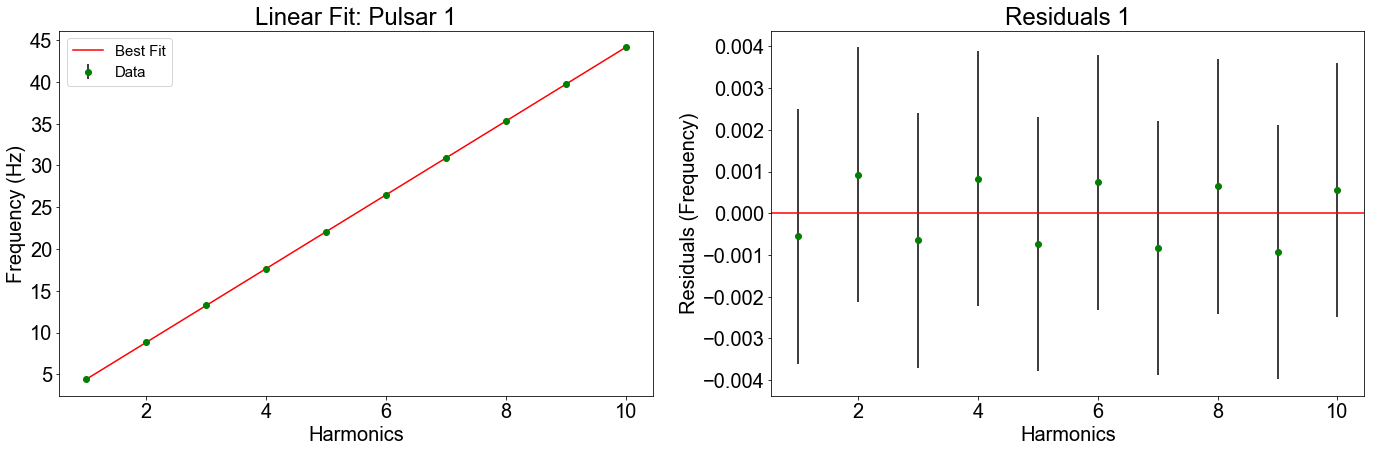

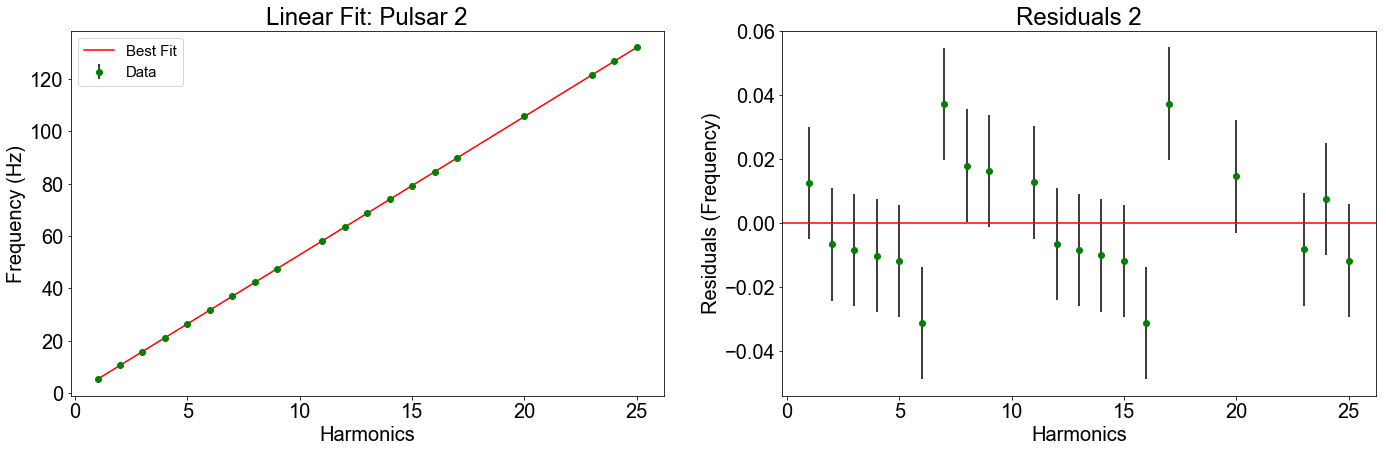

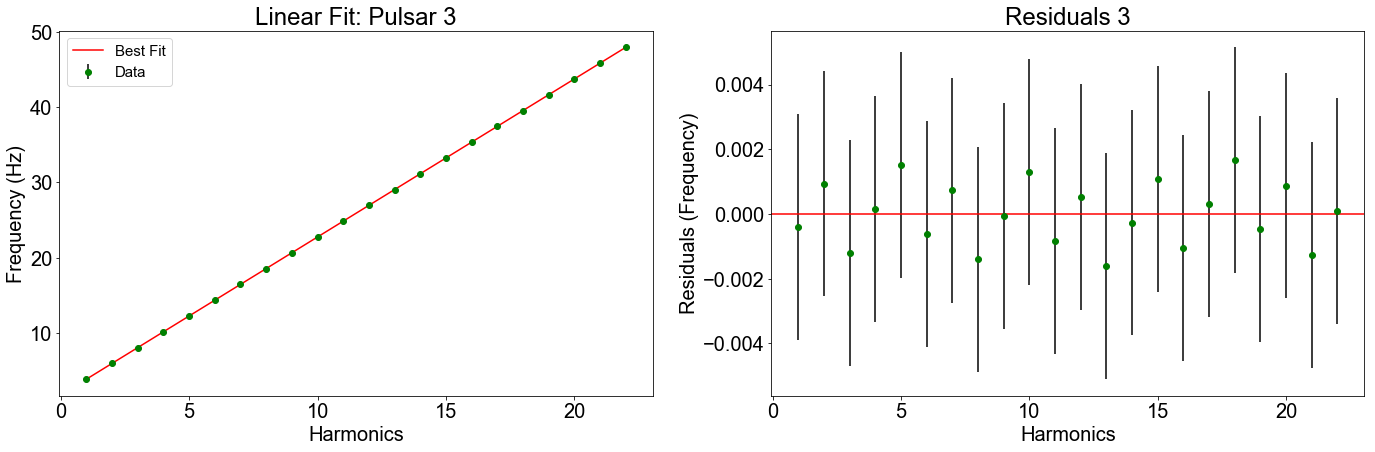

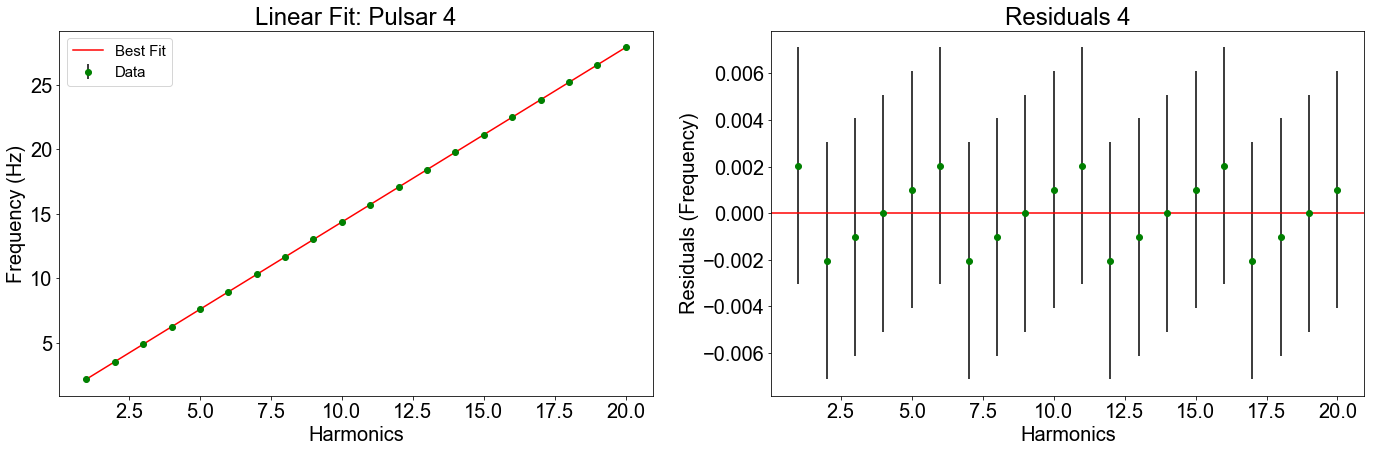

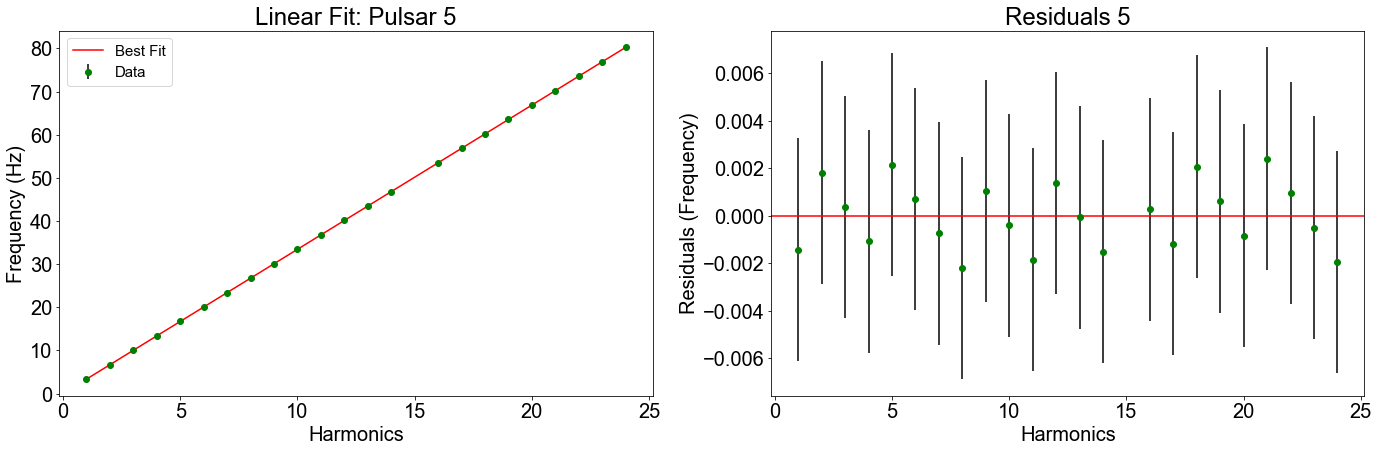

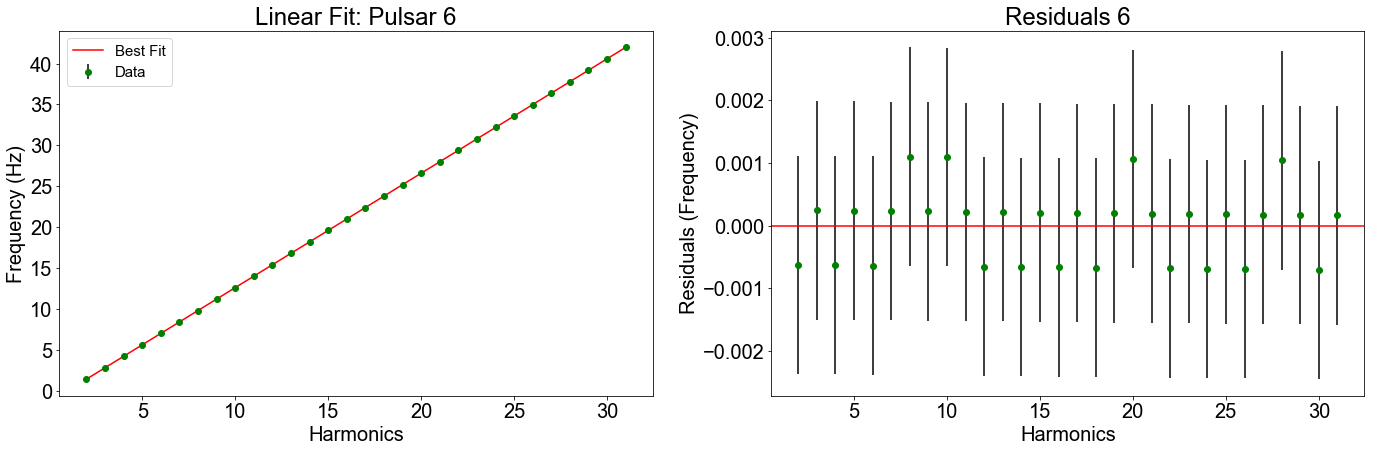

In [30]:
plot_fit(new_h_0_, f_peak0_,   freq_fit0, res_f_0, '1') 
plot_fit(new_h_1i_new, f_peak1i_new ,     freq_fit1, res_f_1, '2') 
plot_fit(new_h_2ii, f_peak2ii,      freq_fit2, res_f_2, '3') 
plot_fit(new_h_3_, f_peak3_, freq_fit3, res_f_3, '4') 
plot_fit(new_h_4_, f_peak4_, freq_fit4, res_f_4, '5') 
plot_fit(new_h_5_,  f_peak5_,  freq_fit5, res_f_5, '6') 

## 2.6 <mark>Method II:</mark> Calculation of the period and its uncertainty

<span style="color:red">
The distance between consecutive frequncy peaks is used to calculate periods and estimate the uncertainty.
</span>

This distance, $d = f_{peak+1}- f_{peak}$,    is given as 1/$p$. Thus, $p$ is plotted as a function of its harmonic number. The mean and standard deviation is also calculated. The uncertainty on the $p$ was propogated from the frequency $f_{peak}$ which arose from the resolution limitation due the set sampling rate. 

Mean Period = 0.2265 +- 0.0002(std)


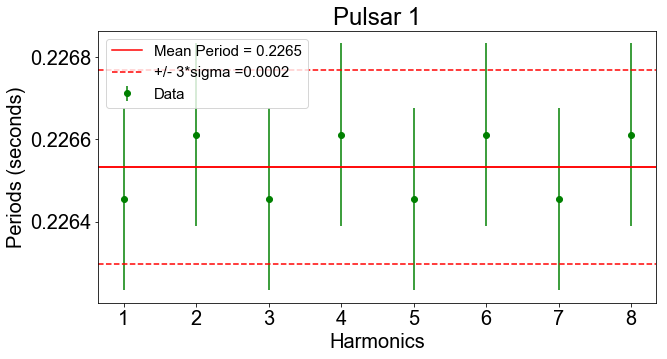

Mean Period = 0.1892 +- 0.0029(std)


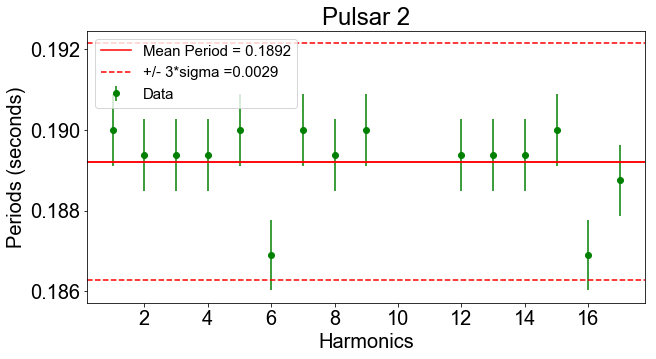

Mean Period = 0.4766 +- 0.0012(std)


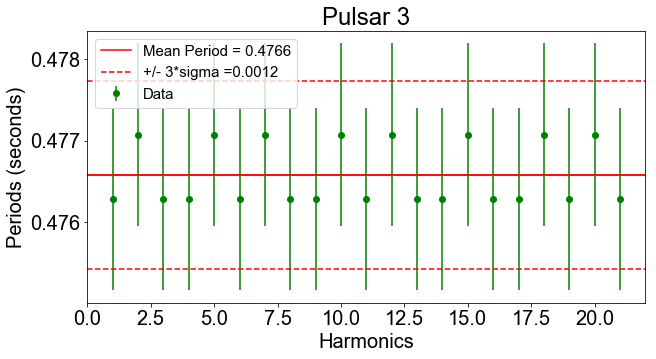

Mean Period = 0.7397 +- 0.0034(std)


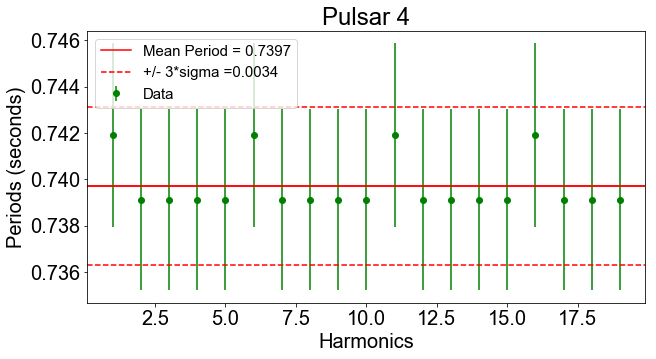

Mean Period = 0.2990 +- 0.0006(std)


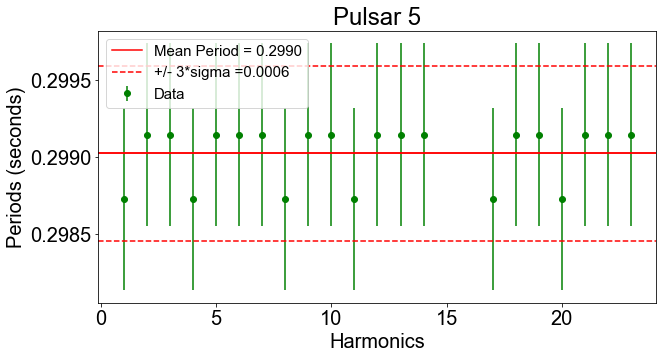

Mean Period = 0.7146 +- 0.0013(std)


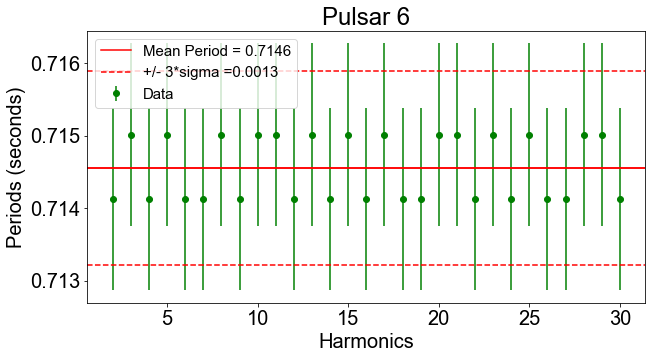

In [31]:
# ------------------------  PULSAR 1 -----------------------------------
p_0, p_err0 = cal_period(f_peak0_, res_f_0)
period0, err0 = plot_period(new_h_0_[:-1], p_0[:-1], p_err0[:-1], '1')

# ------------------------  PULSAR 2 -----------------------------------
p_1, p_err1 = cal_period(f_peak1i_new, res_f_1)
# eliminating points which are biasing the data
if (len(p_1))==19:
    p_1i, p_err1_i, harm1_i = delete_3_arr_points(p_1, p_err1, new_h_1i_new, -3)
if (len(p_1i)) == 18:
    p_1ii, p_err1_ii, harm1_ii = delete_3_arr_points(p_1i, p_err1_i, harm1_i, -3)
if (len(p_1ii))== 17:
    p_1iii, p_err1_iii, harm1_iii = delete_3_arr_points(p_1ii[:-1], p_err1_ii[:-1], harm1_ii[:-1],
                                                        -8)
period1, err1 = plot_period(harm1_iii, p_1iii, p_err1_iii, '2')

# ------------------------  PULSAR 3 -----------------------------------
p_2, p_err2 = cal_period(f_peak2ii, res_f_2)
period2, err2 = plot_period(new_h_2ii, p_2, p_err2, '3')

# ------------------------  PULSAR 4 -----------------------------------
p_3, p_err3 = cal_period(f_peak3_, res_f_3)  
period3, err3 = plot_period(new_h_3_, p_3, p_err3, '4')

# ------------------------  PULSAR 5 -----------------------------------
p_4, p_err4 = cal_period(f_peak4_, res_f_4) 

if (len(p_4))==22:
    p_4i, p_err4_i, harm4_i = delete_3_arr_points(p_4, p_err4, new_h_4_, -9)

period4, err4 = plot_period(harm4_i, p_4i, p_err4_i, '5')

# ------------------------  PULSAR 6 -----------------------------------
p_5, p_err5 = cal_period(f_peak5_, res_f_5)   
period5, err5 = plot_period(new_h_5_, p_5, p_err5, '6')


## 2.7 Calculating the <u>width</u> of the pulse profile for each pulsar

The width, $w$, of the pulse profile can be estimated using the formula,
$$w = P/2N$$
where $P$ is the period of the pulsar and $N$ is the total number of harmonics observed for the integrated time.

In [32]:
width0, err_w0 = cal_width(period0 , new_h_0_ , err0 , '1') 
width1, err_w1 = cal_width(period1 , new_h_1i , err1 , '2') 
width2, err_w2 = cal_width(period2 , new_h_2ii, err2 , '3') 
width3, err_w3 = cal_width(period3 , new_h_3_ , err3 , '4') 
width4, err_w4 = cal_width(period4 , harm4_i  , err4 , '5') 
width5, err_w5 = cal_width(period5 , new_h_5_ , err5 , '6') 

Width of Pulsar 1 ~ (0.01133 ± 0.00001)s

Width of Pulsar 2 ~ (0.00197 ± 0.00003)s

Width of Pulsar 3 ~ (0.01083 ± 0.00003)s

Width of Pulsar 4 ~ (0.01849 ± 0.00009)s

Width of Pulsar 5 ~ (0.00623 ± 0.00001)s

Width of Pulsar 6 ~ (0.01153 ± 0.00002)s

